In [1]:
# Necessary imports.
import math
import copy
import numpy as np
from scipy.sparse import csr_matrix

# Data Address.
DATA = "/home/twig/data/code/babycal/bcal_generator/output_test_1.txt"
# DATA = "/home/twig/shared/data/babycal/output.txt"j
# DATA = "/home/twig/shared/data/babycal/output_test_1.txt"

# Define these based on the input file (TODO: Should be written into this file).
NROWS = 11
NCOLS = 11

# === CONSTANTS =======================================================================
# Generic strings.
HBANK  = "header bank"
UHBANK = "user header bank"
IRBANK = "integrated raw bank"
IDBANK = "integrated digitized bank"
GPBANK = "generated particles bank"

# Strings hardcoded into input file.
S_HBANK    = " --- Header Bank --"
S_UHBANK   = " --- User Header Bank --"
S_IRBANK   = "   -- integrated true infos bank  (51, 0) --"
S_IDBANK   = "   -- integrated digitized bank  (52, 0) --"
S_GPBANK   = " --- Generated Particles Bank --"
S_EOE      = " ---- End of Event  ----"
S_PARTICLE = "Particle"
S_HIT      = "Hit"
S_NHITS    = "nhits"
S_HITN     = "hitn"
S_VOL      = "id"
S_X        = "avg_x"
S_Y        = "avg_y"
S_T        = "avg_t"
S_E        = "totEdep"

# Derived variables.
NROWSA = (NROWS + 1)/2
NROWSB = (NROWS - 1)/2
SENSOR1A_ID =  4
SENSOR2A_ID =  5
SENSOR1B_ID = 14
SENSOR2B_ID = 15

STRIP_RADIUS = 0.050
CORE_RADIUS  = 0.046
DELTAX = (2.*STRIP_RADIUS * NCOLS)/2.
DELTAY = (2.*STRIP_RADIUS + (STRIP_RADIUS * (1.732050808 + 1)) * (NROWS - 1))/2.

In [2]:
def store_metadata(file):
    """
    Store file's metadata as a dictionary of strings.
    :param file: unprocessed input file.
    :return:     dictionary of metadata.
    """
    metadata = {}
    filetype = False # Recent files have an embedded json for some reason.

    for i in range(2):
        devnull = file.readline() # Ignore the first two lines.

    while True:
        x = file.tell() # Define a stopping point for later.
        l = file.readline()
        if len(l) <= 4:
            filetype = True
            break
        if l[3] != '>':
            break
        sl = l.split(' ')
        if len(sl) == 7:
            metadata[sl[5]] = sl[6][:-1]

    if filetype:
        while True:
            x = file.tell()
            l = file.readline()
            if len(l) <= 4: continue
            if l[1] == '-': break

    file.seek(x)
    return metadata

def store_event(file):
    """
    Store one event's data as a dictionary of dictionaries, assuming that the metadata has already been stored.
    :param file: input file with metadata (and pesky embedded json) removed.
    :return:     a dict with 5 dicts whose keys are the 5 BANK constants. Each describes the following:
                   * HBANK:  header bank (10).
                   * UHBANK: user header bank (currently empty). Assumed to have same format as header bank.
                   * IRBANK: integrated raw bank (51).
                   * IDBANK: integrated digitized bank (52).
                   * GPBANK: generated particles bank.
    """
    event_data = {
        HBANK  : {},
        UHBANK : {},
        IRBANK : {},
        IDBANK : {},
        GPBANK : {},
    }
    bank = None
    eof = 0 # End of file checker.

    while True:
        l = file.readline()
        l = l[:-1].rstrip()
        if l == S_EOE: 
            break
        if l == '':
            eof = 1
            break

        # Make sure we're writing to the correct address.
        if   l == S_HBANK:  bank = HBANK
        elif l == S_UHBANK: bank = UHBANK
        elif l == S_IRBANK: bank = IRBANK
        elif l == S_IDBANK: bank = IDBANK
        elif l == S_GPBANK: bank = GPBANK

        if bank != GPBANK:
            sl = l.split('\t')
            if len(sl) == 1: continue # Ignore lines with titles & irrelevant information.

        if bank == HBANK or bank == UHBANK: # Header & user header banks.
            event_data[bank][sl[0].split(' ')[-1][:-1]] = sl[1]
        if bank == IRBANK or bank == IDBANK: # Raw & Digitized banks.
            event_data[bank][sl[0].split(' ')[-1][:-1]] = sl[1:]
        if bank == GPBANK: # Generated particles bank.
            sl = l.split()
            if sl[1] == S_PARTICLE:
                event_data[bank][sl[ 3][:-1]] = sl[ 4]
                event_data[bank][sl[ 6][:-1]] = sl[ 7]
                event_data[bank][sl[10][:-1]] = sl[11]
            if sl[1] == S_HIT:
                event_data[bank][S_NHITS] = sl[ 4]
                event_data[bank][sl[ 7]]  = sl[ 8]
                event_data[bank][sl[11]]  = sl[12]
    if eof != 0:
        return None

    return event_data

def save_file(addr, nevents=0):
    """
    Store a GEMC file's metadata and events in a tuple.
    :param addr:    address of the input file in standard GEMC txt format.
    :param nevents: number of events to read. Set to 0 to read all events.
    :return:        a 2-tuple with a dictionary containing the file's metadata (0) and an array of events (1).
                    Both the metadata's and each event's formats are described in the store_metadata() and
                    store_event() methods.
    """
    f = open(addr)

    metadata = store_metadata(f)
    events  = []

    nevent = 0
    while True:
        nevent += 1
        event = store_event(f)
        if not event: break # Reached end of file.
        events.append(event)
        if nevents != 0 and nevent >= nevents: break
    f.close()

    return (metadata, events)

In [3]:
# Extract hits from an event.
def extract_hits(event):
    """
    Extract hits from an event.
    :param event: one event in the format defined by the store_event() method.
    :return:      a 2-tuple containing dictionaries describing the hits in arrays. Dictionaries' keys are the
                  following:
                    * n: hit identifier. Unused by this program, but useful in reconstruction.
                    * x: x position of the hit in cm.
                    * y: y position of the hit in cm.
                    * t: time of the hit in ns (t=0 is defined as the moment when the event takes place).
                    * E: energy deposited by the hit.
    """
    if event == None: return None
    # Define hits dictionaries (one per detecting surface).
    hits = ({'n' : [], 'x' : [], 'y' : [], 't' : [], 'E' : [],},
            {'n' : [], 'x' : [], 'y' : [], 't' : [], 'E' : [],},)

    for hi in range(len(event[IDBANK][S_HITN])):
        # TODO: UNCOMMENT WHEN VOLUMES ISSUE IS SOLVED!
        if event[IRBANK]["pid"]    [hi] != '0': continue # Ignore hits that don't come from photons.
        if event[IRBANK]["totEdep"][hi] == '0': continue # Ignore hits with no energy deposited.
        vol = -1 # Save the volume hit.
        volid = int(int(event[IDBANK][S_VOL][hi])/10**8)
        if volid == SENSOR1A_ID or volid == SENSOR1B_ID: vol = 0
        if volid == SENSOR2A_ID or volid == SENSOR2B_ID: vol = 1
        if vol == -1: continue

        # Add hit to dictionary.
        hits[vol]['n'].append(float(event[IDBANK][S_HITN][hi]))  # hit identifier.
        hits[vol]['x'].append(float(event[IRBANK][S_X][hi])/10.) # x position (in cm).
        hits[vol]['y'].append(float(event[IRBANK][S_Y][hi])/10.) # y position (in cm).
        hits[vol]['t'].append(float(event[IRBANK][S_T][hi]))     # Time.
        hits[vol]['E'].append(float(event[IRBANK][S_E][hi]))     # Energy deposited.

    return hits

In [4]:
def generate_timeseries(hits, dt, dx, dy):
    """
    Generates a time series of sparse 2-dimensional matrices from a list of hits.
    :param hits: list of hits in the output format of the extract_hits() method.
    :param dt:   delta t of the time series.
    :param dx:   size of the matrix's columns. Doesn't need to divide the total x size of the detector.
    :param dy:   size of the matrix's rows. Doesn't need to divide the total y size of the detector.
    :return:     an array of 2-dimensional sparse matrix as per scipy sparce's csr_matrix definition. To further
                 reduce storage use, if not hits are found for a dt a null object is stored instead of an empty
                 matrix.
    """
    if not hits: return None
    chits = copy.deepcopy(hits) # NOTE: Maybe overkill.

    tseries = []
    max_t = 0.
    for t in chits['t']:
        if t > max_t: max_t = t

    for t in np.arange(0., max_t, dt):
        hitstored = False
        m = np.zeros((int(math.ceil(2*DELTAY/dy)), int(math.ceil(2*DELTAX/dx))))

        for hi in range(len(chits['n'])-1, -1, -1):
            # Check if hit is in dt.
            if t > chits['t'][hi] or t+dt <= chits['t'][hi]: continue

            # Store hit's position.
            sx = None
            for x in np.arange(-DELTAX, DELTAX+dx, dx):
                if x <= chits['x'][hi] and chits['x'][hi] < x+dx: sx = x
            sy = None
            for y in np.arange(-DELTAY, DELTAY+dy, dy):
                if y <= chits['y'][hi] and chits['y'][hi] < y+dy: sy = y
            if not sx or not sy:
                # NOTE: There is a very particular case where this might happen "by accident". If either dx or dy
                #       perfectly divides 2*DELTAX or 2*DELTAY respectively, and a hit happens exactly at an
                #       edge... kaboom. The probability of this happening is so low that I don't think adding the
                #       extra computing time and error checking is worth it.
                print("Something is deeply wrong in the input data. Exiting...")
                return None

            m[int((DELTAY+sy)/dy)][int((DELTAX+sx)/dx)] += chits['E'][hi]

            for key in chits.keys():
                chits[key].pop(hi)
            hitstored = True

        if not hitstored: tseries.append(None)
        else:             tseries.append(csr_matrix(m))
    return tseries

# Tests

In [5]:
# Imports only for checking results.
np.seterr(all="warn")
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pprint
pp = pprint.PrettyPrinter(indent=4, width=100, compact=True)

In [6]:
events = save_file(DATA)[1]

hitsarr = []
for event in events:
    hits = extract_hits(event)
    if hits[0]['E'] or hits[1]['E']: hitsarr.append(hits)

Plate 1:
t = 0.00:
  No hits.

t = 0.05:
  No hits.

t = 0.10:
  No hits.

t = 0.15:
  No hits.

t = 0.20:
  No hits.

t = 0.25:


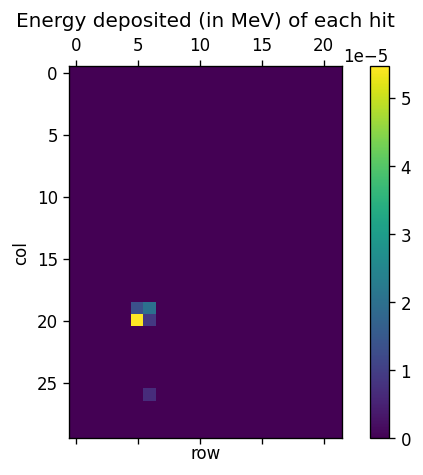

t = 0.30:


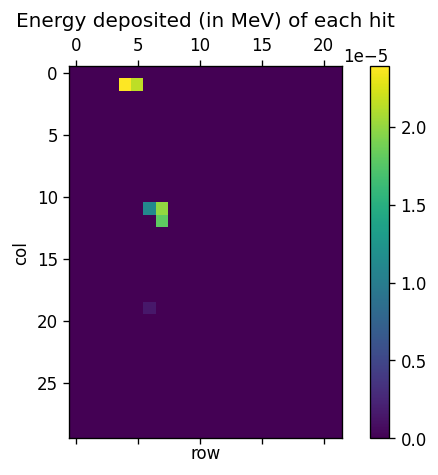

Plate 2:
t = 0.00:
  No hits.

t = 0.05:
  No hits.

t = 0.10:
  No hits.

t = 0.15:
  No hits.

t = 0.20:
  No hits.

t = 0.25:


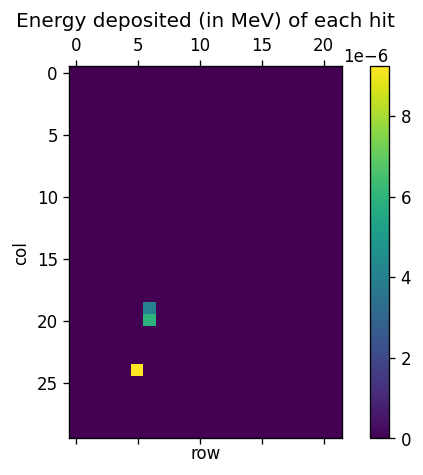

t = 0.30:


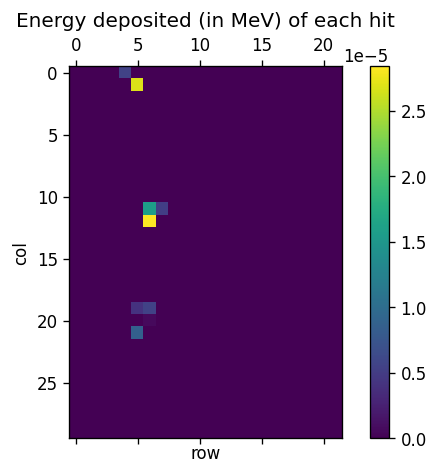

t = 0.35:


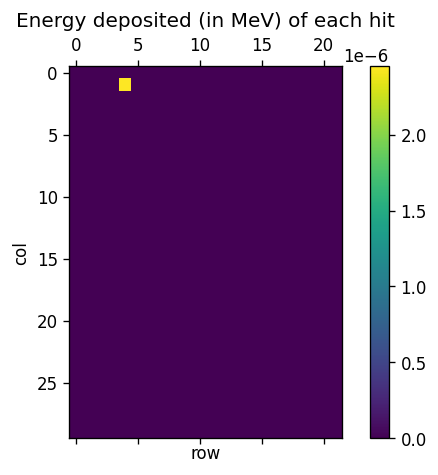

In [8]:
dt = 0.05
dx = 0.05
dy = 0.05

for hits in hitsarr:
    tseries = (generate_timeseries(hits[0], dt, dx, dy), generate_timeseries(hits[1], dt, dx, dy))
    for i in range(len(tseries)):
        if i == 0: print("Plate 1:")
        if i == 1: print("Plate 2:")
        
        for ti in range(len(tseries[i])):
            print("t = %4.2f:" % (ti*dt))
            if tseries[i][ti] == None: print("  No hits.\n")
            else: 
                plt.figure(num=1, figsize=(6, 4), dpi=120, facecolor='w', edgecolor='k')
                plt.matshow(tseries[i][ti].todense(), fignum=1);
                plt.colorbar()
                plt.title("Energy deposited (in MeV) of each hit")
                plt.xlabel("row")
                plt.ylabel("col")
                plt.show()